In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2


from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
df = pd.read_csv("E:\\Face Emotion Detection\\fer2013.csv")

In [3]:
print(df)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]
       emotion            

In [4]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


## Exploraotry Data Analysis ##

In [5]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [6]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

## No of images present in dataset corresponding to each emotion ##

In [7]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


## No of images present in dataset corresponding to training testing and validation part ##

In [8]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


## Visualizing images from the dataset ##

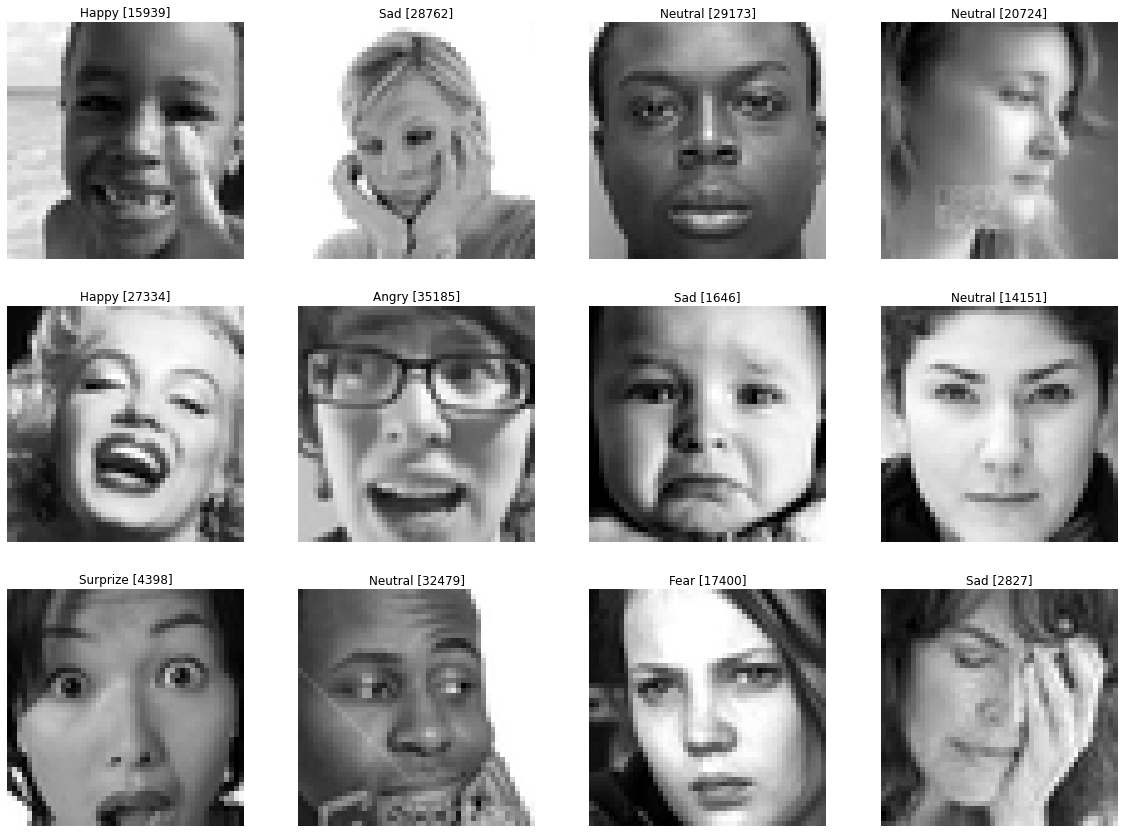

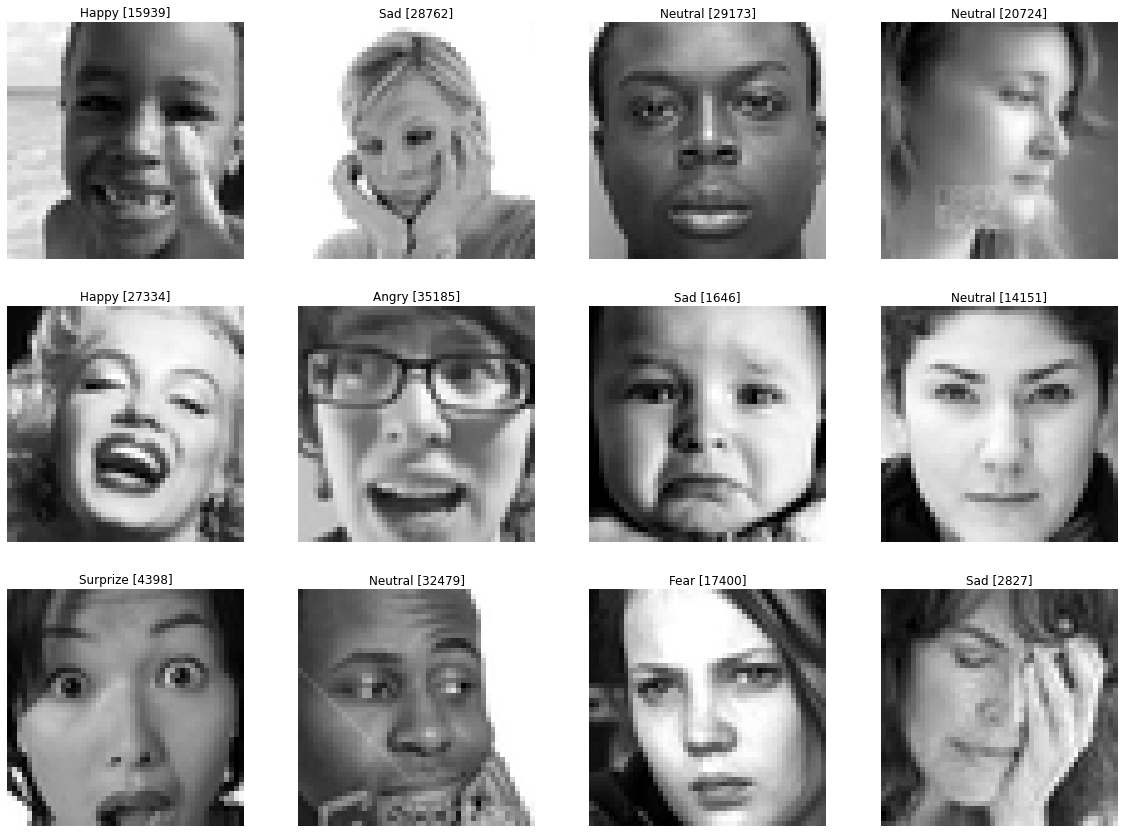

In [9]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

## Data Preprocessing ##

## Extracting rows for each part ##

In [10]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

In [11]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 2304), (28709,), (3589, 2304), (3589,), (3589, 2304), (3589,))

((28709, 2304), (28709,), (3589, 2304), (3589,), (3589, 2304), (3589,))

## As you can see above we have to change the shape of the images to train them as the above shape is not compatible ##

In [12]:
X_train = X_train.reshape(X_train.shape[0],48,48,1)
X_test = X_test.reshape(X_test.shape[0],48,48,1)
X_val = X_val.reshape(X_val.shape[0],48,48,1)

y_train = to_categorical(y_train,num_classes=7) 
y_test = to_categorical(y_test,num_classes=7)
y_val = to_categorical(y_val,num_classes=7)

X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

## Defining Model Archietechture ##
VGG16

In [13]:
def cnn_model():
    
    model = Sequential()

    model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
    model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
    model.add(ZeroPadding2D((1,1),name="block1_pad2"))
    model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
    model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

    model.add(ZeroPadding2D((1,1),name="block2_pad1"))
    model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
    model.add(ZeroPadding2D((1,1),name="block2_l2"))
    model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
    model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

    model.add(ZeroPadding2D((1,1),name="block3_pad1"))
    model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
    model.add(ZeroPadding2D((1,1),name="block3_pad2"))
    model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
    model.add(ZeroPadding2D((1,1),name="block3_pad3"))
    model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
    model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))
    
    model.add(ZeroPadding2D((1,1),name="block4_pad1"))
    model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
    model.add(ZeroPadding2D((1,1),name="block4_pad2"))
    model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
    model.add(ZeroPadding2D((1,1),name="block4_pad3"))
    model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
    model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


    model.add(ZeroPadding2D((1,1),name="block5_pad1"))
    model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
    model.add(ZeroPadding2D((1,1),name="block5_pad2"))
    model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
    model.add(ZeroPadding2D((1,1), name="block5_pad3"))
    model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
    model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu',name="block6"))
    model.add(Dropout(0.5,name="drop1"))
    model.add(Dense(4096, activation='relu',name="block7"))
    model.add(Dropout(0.5,name="drop2"))
    model.add(Dense(7, activation='softmax',name="block8"))

    return model
  

In [14]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
Model: "sequential"
_________________________________________________________________
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer (type)                Output Shape              Param #   
 block1_pad1 (ZeroPadding2D)  (None, 50, 50, 1)        0         
 block1_pad1 (ZeroPadding2D)  (None, 50, 50, 1)        0         
                                                                 
 block1_l1 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
                                                                 
 block1_l1 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 block1_pad2 (ZeroPadding2D)  (None, 50, 50, 64)       0         
 block1_pad2 (ZeroPadding2D)  (None, 50, 50, 64)       0         
                                    

 flatten (Flatten)           (None, 512)               0         
                                                                 
 block6 (Dense)              (None, 4096)              2101248   
 block5_pad3 (ZeroPadding2D)  (None, 5, 5, 512)        0         
                                                                 
 block5_l3 (Conv2D)          (None, 3, 3, 512)         2359808   
                                                                 
 pool5 (MaxPooling2D)        (None, 1, 1, 512)         0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 block6 (Dense)              (None, 4096)              2101248   
                                                                 
                                                                 
 drop1 (Dropout)             (None, 4096)              0         
          

In [15]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=5,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

Epoch 1/30
Epoch 1/30
898/898 [==============================] - ETA: 0s - loss: 1.8245 - accuracy: 0.2472
Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to best_model.h5

Epoch 1: val_accuracy improved from -inf to 0.24937, saving model to best_model.h5
898/898 [==============================] - 1557s 2s/step - loss: 1.8245 - accuracy: 0.2472 - val_loss: 1.8104 - val_accuracy: 0.2494
Epoch 2/30
Epoch 2/30
898/898 [==============================] - ETA: 0s - loss: 1.7695 - accuracy: 0.2768
Epoch 2: val_accuracy improved from 0.24937 to 0.34216, saving model to best_model.h5

Epoch 2: val_accuracy improved from 0.24937 to 0.34216, saving model to best_model.h5
898/898 [==============================] - 1614s 2s/step - loss: 1.7695 - accuracy: 0.2768 - val_loss: 1.6730 - val_accuracy: 0.3422
Epoch 3/30
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 1.6057 - accuracy: 0.3672
Epoch 3: val_accuracy improved from 0.34216 to 0.35469, saving model to b

Epoch 27/30
898/898 [==============================] - ETA: 0s - loss: 0.1010 - accuracy: 0.9675
Epoch 27: val_accuracy improved from 0.59181 to 0.59292, saving model to best_model.h5
898/898 [==============================] - 1496s 2s/step - loss: 0.1010 - accuracy: 0.9675 - val_loss: 2.5180 - val_accuracy: 0.5929
Epoch 28/30
898/898 [==============================] - ETA: 0s - loss: 0.0898 - accuracy: 0.9719
Epoch 28: val_accuracy did not improve from 0.59292
898/898 [==============================] - 1488s 2s/step - loss: 0.0898 - accuracy: 0.9719 - val_loss: 2.2627 - val_accuracy: 0.5874
Epoch 29/30
898/898 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9751
Epoch 29: val_accuracy did not improve from 0.59292
898/898 [==============================] - 1486s 2s/step - loss: 0.0808 - accuracy: 0.9751 - val_loss: 2.3368 - val_accuracy: 0.5846
Epoch 30/30
898/898 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9774
Epoch 30: val_accuracy

## Model Evaluation ##

Lets see the output resutls

Loss plot
Images with their predicted vs actual label
Confusion Matrix
Classification Reprot

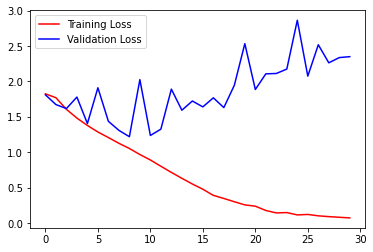

In [16]:
def loss_plot(history):
    plt.plot(history.history["loss"],'r', label="Training Loss")
    plt.plot(history.history["val_loss"],'b', label="Validation Loss")
    plt.legend()

loss_plot(history)

In [17]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 50s 402ms/step


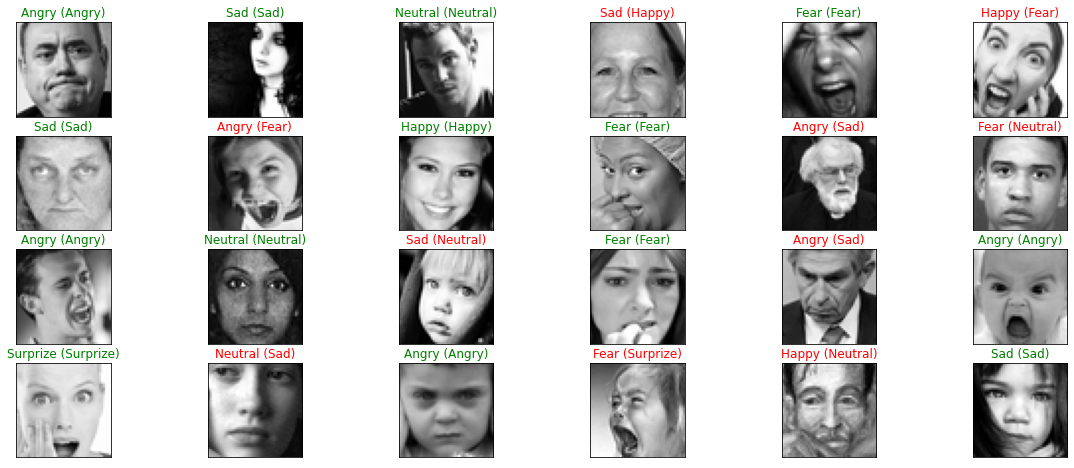

In [18]:
def check_images(X_test,y_pred,label_dict={}):

    figure = plt.figure(figsize=(20, 8))
    for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
        ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[index]),cmap="gray")
        predict_index = label_dict[(y_pred[index])]
        true_index = label_dict[np.argmax(y_test,axis=1)[index]]
      
        ax.set_title("{} ({})".format((predict_index), 
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(X_test,y_pred,emotions)

In [19]:
def conf_mat(y_test,y_pred,labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]):
    CLASS_LABELS  = labels
    cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
    cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    plt.figure(figsize = (20,10))
    plt.title('Confusion Matrix', fontsize = 20)
    sns.set(font_scale=1.2)
    ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

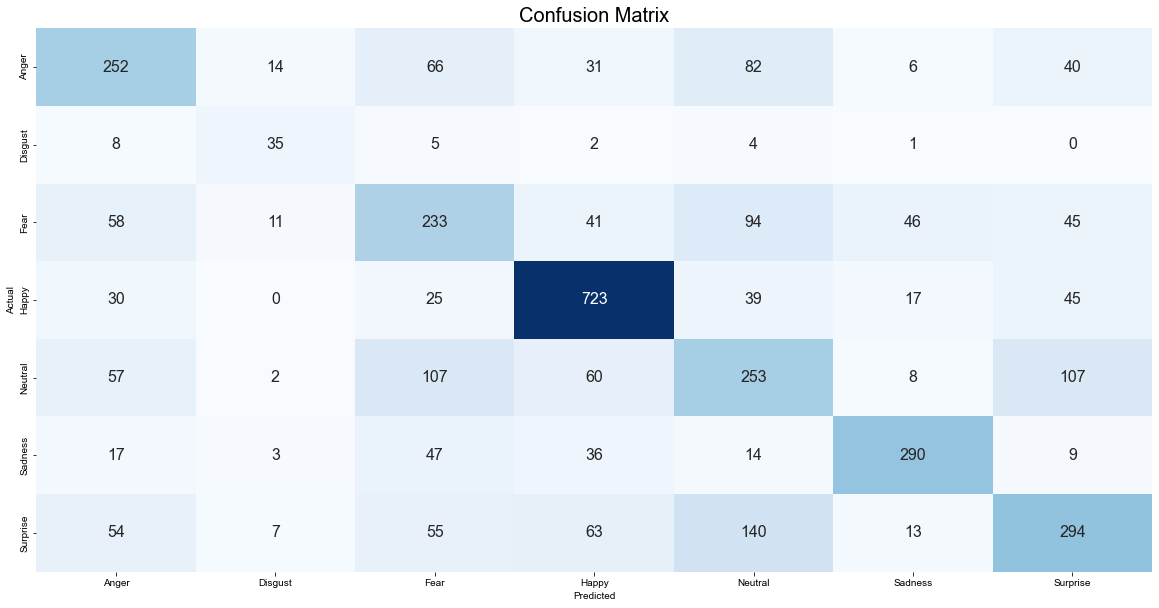

In [20]:
conf_mat(y_test,y_pred)

In [21]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.529     0.513     0.521       491
           1      0.486     0.636     0.551        55
           2      0.433     0.441     0.437       528
           3      0.756     0.823     0.788       879
           4      0.404     0.426     0.415       594
           5      0.761     0.697     0.728       416
           6      0.544     0.470     0.504       626

    accuracy                          0.580      3589
   macro avg      0.559     0.572     0.563      3589
weighted avg      0.579     0.580     0.578      3589



In [22]:
loss_and_metrics = model.evaluate(X_train,y_train)
print("On Training Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_val,y_val)
print("On Validation Data",loss_and_metrics)

loss_and_metrics = model.evaluate(X_test,y_test)
print("On Test Data",loss_and_metrics)

898/898 [==============================] - 331s 368ms/step - loss: 0.0578 - accuracy: 0.9816
On Training Data [0.057817913591861725, 0.9815737009048462]
113/113 [==============================] - 41s 358ms/step - loss: 2.3495 - accuracy: 0.5890
On Validation Data [2.3494973182678223, 0.5890220403671265]
113/113 [==============================] - 40s 354ms/step - loss: 2.3067 - accuracy: 0.5795
On Test Data [2.306652307510376, 0.5795485973358154]


## Fine Tuning ##

Let's try to improve the model

## 1. Changing epoch, learning rate and batch size ##

In [ ]:
model = cnn_model()
model.compile(optimizer=SGD(learning_rate=0.005),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

Epoch 1/60
449/449 [==============================] - ETA: 0s - loss: 1.8306 - accuracy: 0.2443
Epoch 1: val_accuracy did not improve from 0.59292
449/449 [==============================] - 1503s 3s/step - loss: 1.8306 - accuracy: 0.2443 - val_loss: 1.8135 - val_accuracy: 0.2494
Epoch 2/60
449/449 [==============================] - ETA: 0s - loss: 1.8126 - accuracy: 0.2502
Epoch 2: val_accuracy did not improve from 0.59292
449/449 [==============================] - 1421s 3s/step - loss: 1.8126 - accuracy: 0.2502 - val_loss: 1.7918 - val_accuracy: 0.2494
Epoch 3/60
449/449 [==============================] - ETA: 0s - loss: 1.7822 - accuracy: 0.2656
Epoch 3: val_accuracy did not improve from 0.59292
449/449 [==============================] - 1412s 3s/step - loss: 1.7822 - accuracy: 0.2656 - val_loss: 1.7521 - val_accuracy: 0.2820
Epoch 4/60
449/449 [==============================] - ETA: 0s - loss: 1.7133 - accuracy: 0.3182
Epoch 4: val_accuracy did not improve from 0.59292
449/449 [====

449/449 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9465
Epoch 30: val_accuracy did not improve from 0.59292
449/449 [==============================] - 1421s 3s/step - loss: 0.1681 - accuracy: 0.9465 - val_loss: 2.6093 - val_accuracy: 0.5408
Epoch 31/60
449/449 [==============================] - ETA: 0s - loss: 0.1511 - accuracy: 0.9521
Epoch 31: val_accuracy did not improve from 0.59292
449/449 [==============================] - 1394s 3s/step - loss: 0.1511 - accuracy: 0.9521 - val_loss: 2.6563 - val_accuracy: 0.5316
Epoch 32/60
449/449 [==============================] - ETA: 0s - loss: 0.1400 - accuracy: 0.9561
Epoch 32: val_accuracy did not improve from 0.59292
449/449 [==============================] - 1393s 3s/step - loss: 0.1400 - accuracy: 0.9561 - val_loss: 2.6687 - val_accuracy: 0.5517
Epoch 33/60
449/449 [==============================] - ETA: 0s - loss: 0.1097 - accuracy: 0.9674
Epoch 33: val_accuracy did not improve from 0.59292
449/449 [========

In [ ]:
loss_plot(history)

In [ ]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

## 2. Changing optimizer ##

In [ ]:
# loss and accuracy

model = cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

In [ ]:
loss_plot(history)

In [ ]:
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

## Observation ##

Seems like the model is getting overfitted by the data and the same arch. is not giving better results after tuning. More steps that can be taken to improve the performance

1.Adding regularization in the model Arch.
2.Adding more data in validation set
3.Try with diff cnn arch

## Model Saving ##

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    model.save_weights("model.h5")
print("Saved model to disk")

## Deploying model using OpenCV ##

Note: Run the below code in your local machine

## loading model arch and weights ##

In [ ]:
model = model_from_json(open("model.json", "r").read())
model.load_weights('best_model.h5')
face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

## Open CV code for webcam and prediction ##

In [ ]:
cap=cv2.VideoCapture(0) # start webcam
while True:
    (valid,test_image)=cap.read() #reading image from video frame
    if not valid: #if not getting frames then exit
        break

    gray_image= cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY) #converting the rgb image to grayscale


    faces_detected = face_haar_cascade.detectMultiScale(gray_image) #detecting faces from the image using haar_cascade
    for (x,y,w,h) in faces_detected: #cordinates of deteced faces
        cv2.rectangle(gray_image,(x,y), (x+w,y+h), (255,0,0)) #putting a rectange box around detected face
        roi_gray=gray_image[y:y+w,x:x+h]  # capturing only face from the image
        roi_gray=cv2.resize(roi_gray,(48,48)) # resizing it to 48,48 (that's what mdodel wants as an input)
        image_pixels = img_to_array(roi_gray) #converting image to array
        image_pixels = np.expand_dims(image_pixels, axis = 0) #expanding dims as model needs input in batches
        # image_pixels /= 255


        predictions = model.predict(image_pixels) #model prediction
        max_index = np.argmax(predictions[0]) #getting emotion index

        emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
        emotion_prediction = emotion_detection[max_index]
        
        
        cv2.putText(test_image, emotion_prediction, (int(x), int(y)),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3) #putting text around face
        cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)  


        resize_image = cv2.resize(test_image, (1000, 700)) #enhancing the image to display
        cv2.imshow('Emotion Dectector',resize_image)
        if cv2.waitKey(10) == ord('b'):
            break
cap.release()
cv2.destroyAllWindows